In [9]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
twitter_df = pd.read_csv('TwitterHate.csv')
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [3]:
twitter_df.sample(10)

,id,label,tweet
8218,8219,0,i love this. #now #grateful #thankyou
10148,10149,0,#thursdaythoughts #thursdaytreat @user #realta...
18331,18332,0,my routine is out of whack! evening walk ð ...
25082,25083,0,jesus the christ (matthew 16:16) #vlicobs #xox...
6872,6873,0,awesome #basement transformation! love the #pa...
29180,29181,0,@user made some pretty big strides with @user...
19650,19651,0,@user getting ready for @user to come on stag...
1424,1425,0,i am thankful for computers. #thankful #positi...
10786,10787,0,#best friends #share #crayons and #color #toge...
21369,21370,0,received my @user friendship bracelets today! ...


In [4]:
twitter_df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

<AxesSubplot:>

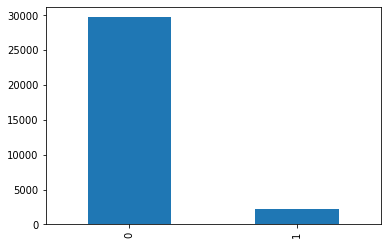

In [5]:
twitter_df['label'].value_counts().plot(kind = 'bar')

In [6]:
twitter_df[twitter_df.duplicated()].count()

id       0
label    0
tweet    0
dtype: int64

In [7]:
twitter_df_updated = twitter_df[['tweet', 'label']].copy()
twitter_df_updated.sample(10)

,tweet,label
15895,have a very good nigth my beautiful people ð...,0
16421,"âto be happy, the only thing you need is to ...",0
22298,i guess some girls need to use a creepy man to...,0
18064,thank youðrinaâ¡hinano #0610 #bihdaypresen...,0
18796,the #horribleteacher that hu my 10yr old son b...,0
31483,@user #jeffsessions thinks we won't notice as ...,1
9872,@user #notmypresident not ever #misogynistic ...,1
22712,"oooh, @user makes sad feel ...if you don't kn...",0
22346,fake activist !!!%####&amp;$/,1
13894,i am cute. #i_am #positive #affirmation,0


In [8]:
twitter_df_updated['tweet'] = twitter_df['tweet'].apply(str.lower)

In [9]:
tweets = twitter_df_updated['tweet'].to_list()

In [10]:
clean_tweets = []
for tweet in tweets:
    words = tweet.split()
    words = [re.sub(r'([@][a-zA-Z0-9]+)','',clean_word) for clean_word in words]
    words = [re.sub(r'(http[s]{0,1}:\/\/)*(www\.)*[a-zA-Z0-9]+\.[a-zA-Z0-9]+','',clean_word) for clean_word in words]
    words = [re.sub(r'#','',clean_word) for clean_word in words]
    clean_tweets.append(' '.join(words))

clean_tweets[0]


' when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. run'

In [11]:
tweet_tokenizer = TweetTokenizer()
tweet_tokens = [tweet_tokenizer.tokenize(text) for text in clean_tweets]

tweet_tokens[0]

['when',
 'a',
 'father',
 'is',
 'dysfunctional',
 'and',
 'is',
 'so',
 'selfish',
 'he',
 'drags',
 'his',
 'kids',
 'into',
 'his',
 'dysfunction',
 '.',
 'run']

In [12]:
lem = WordNetLemmatizer()

root_tokens = [[lem.lemmatize(word) for word in text ] for text in tweet_tokens]

stop_words = stopwords.words('english')

stop_words +=  ['rt', 'amp']

In [13]:
clean_data = []
for tweet in tweet_tokens:
    clean_data.append([ token for token in tweet if token not in stop_words and len(token) > 1 and token.isalpha()])

clean_data[:3]

[['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run'],
 ['thanks',
  'lyft',
  'credit',
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty']]

In [14]:
freq_terms = []

for sent in clean_data:
    freq_terms+= sent

In [15]:
Counter(freq_terms).most_common(10)

[('love', 2680),
 ('day', 2273),
 ('happy', 1683),
 ('time', 1128),
 ('life', 1103),
 ('like', 1097),
 ('today', 1006),
 ('new', 988),
 ('positive', 929),
 ('thankful', 920)]

In [16]:
clean_data= [' '.join(text) for text in clean_data]

In [17]:

X =  np.array(clean_data)

y = twitter_df_updated['label']

len(X),len(y)

(31962, 31962)

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size= 0.7, random_state= 1)

In [19]:
text_vect = TfidfVectorizer(max_features = 5000)
text_vect.fit(X_train)
X_train_transform = text_vect.transform(X_train)
X_test_transform = text_vect.transform(X_test)

In [20]:
def train_model(X_train = X_train_transform, y_train = y_train, X_test=X_test_transform, y_test =y_test):
    model = LogisticRegression(**params)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return [confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred, output_dict = True) ]


In [21]:
def model_matrix(cm):
    with plt.style.context('dark_background'):
        f = sns.heatmap(cm, annot=True, fmt='d')
        f.set_title("confusion_matrix" , color = "white")
        plt.xlabel("Predicted label " , color = "white")
        plt.ylabel("True label " , color = "white")
        plt.show()

In [22]:
def model_class_report(class_report):
    class_report = pd.DataFrame(class_report)
    with plt.style.context('dark_background'):
      plt.figure(figsize=(13.42,7))
      f = sns.heatmap(class_report.iloc[:-1, :].T, cmap='YlGnBu', annot=True, fmt='.3f')
      f.set_title('Classification report' , color = "white")
      plt.xlabel("Score " , color = "white")
      plt.ylabel("Models " , color = "white")

In [23]:
params = {
    
}

cm , class_report = train_model()

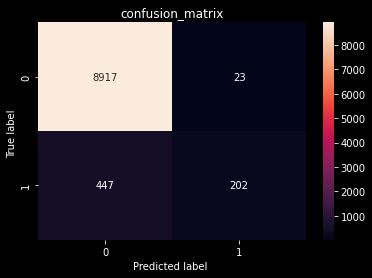

In [24]:
model_matrix(cm)

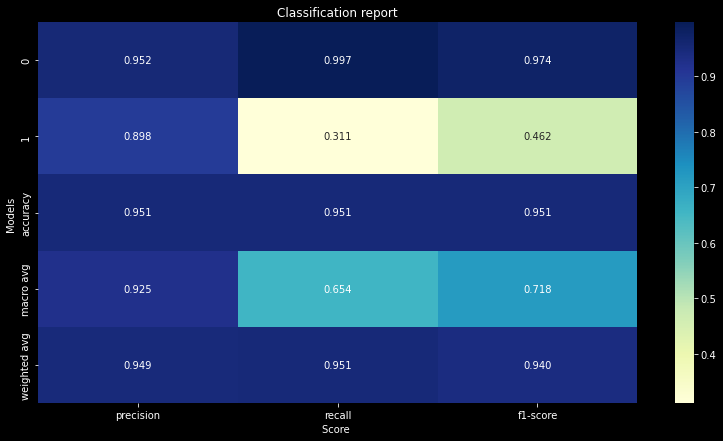

In [25]:
model_class_report(class_report)

In [26]:
params = {
    'class_weight': 'balanced'
}
cm , class_report = train_model()

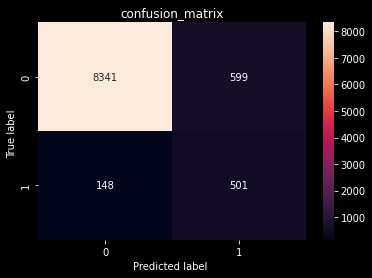

In [27]:
model_matrix(cm)

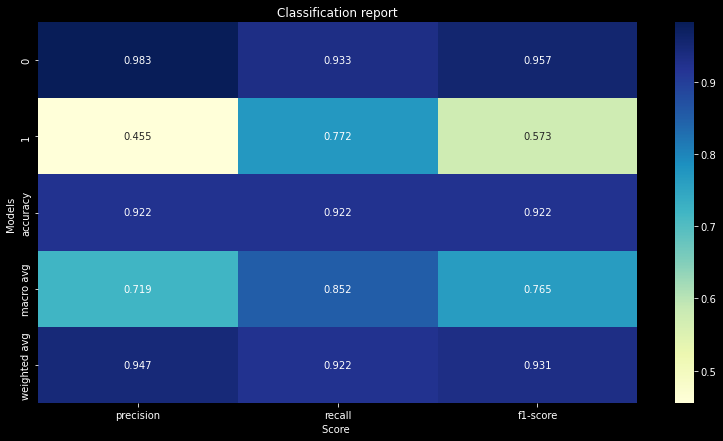

In [28]:
model_class_report(class_report)

In [29]:
model = LogisticRegression(class_weight= 'balanced')
grid_values = {
            'penalty': ['l2'],
            'C':[0.001,0.01,0.09,0.1,1,5,10] ,
            'max_iter': [500 ,1000,5000],
        }

grid_model = GridSearchCV(model, param_grid = grid_values,scoring = 'recall',error_score= 'raise' ,n_jobs = -1)
grid_model.fit(X_train_transform, y_train)
y_pred = grid_model.predict(X_test_transform)

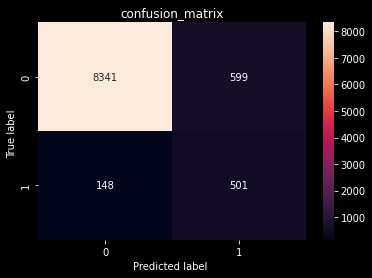

In [30]:
model_matrix(confusion_matrix(y_test, y_pred))

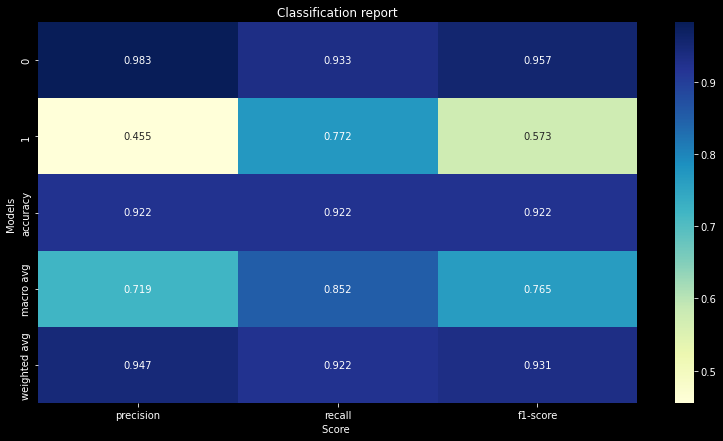

In [31]:
model_class_report(classification_report(y_test, y_pred, output_dict = True))

In [32]:
grid_model.best_params_

{'C': 1, 'max_iter': 500, 'penalty': 'l2'}

In [33]:
params = {
     'C': 0.1,
     'max_iter': 500,
     'penalty': 'l2',
     'class_weight': 'balanced'
}

cm , class_report = train_model()

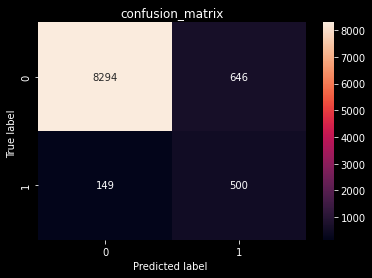

In [34]:
model_matrix(cm)

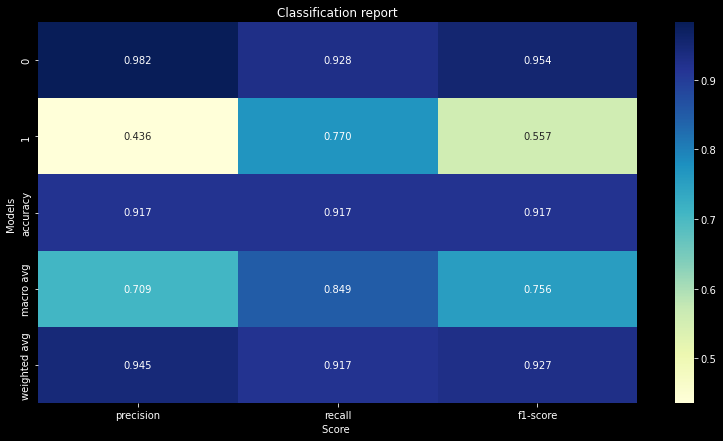

In [35]:
model_class_report(class_report)

In [36]:
def plot_result():
  evaluation_results = pd.DataFrame(np.zeros((4,4)), columns=['Accuracy', 'Macro AVG Precision','Macro AVG Recall','Macro AVG F1-score'])
  evaluation_results.index=index
  for i in range(len(result)):
    evaluation_results.iloc[i]['Accuracy'] = result[i][1]['accuracy']
    evaluation_results.iloc[i]['Macro AVG F1-score'] = result[i][1]['macro avg']['f1-score']  
    evaluation_results.iloc[i]['Macro AVG Precision'] = result[i][1]['macro avg']['precision']
    evaluation_results.iloc[i]['Macro AVG Recall'] = result[i][1]['macro avg']['recall']
  with plt.style.context('dark_background'):
    plt.figure(figsize=(13.42,7))
    f = sns.heatmap(evaluation_results, cmap='YlGnBu', annot=True, fmt='.3f')
    f.set_title("Model score" , color = "white")
    plt.xlabel("Score " , color = "white")
    plt.ylabel("Models " , color = "white")



In [37]:
def plot_matrix():
  colors = ['coolwarm', 'icefire']
  size  = len(result)//2
  with plt.style.context('dark_background'):
    fig, axs = plt.subplots(size, 2,figsize=(15,15))
  count = 0
  for i in range(size):
    for j in range(2):
          f = sns.heatmap(result[count][0],cmap= colors[j], annot=True, fmt='d',ax=axs[i][j] , cbar=(i,j))
          axs[i][j].set_title('Confusion Matrix for {}'.format(index[count]) , color = "white")
          axs[i][j].set_xlabel("Predicted label " , color = "white")
          axs[i][j].set_ylabel("True label " , color = "white")
          count+=1
          if(count >len(result)):
            break
  plt.show()

In [38]:
skf = StratifiedKFold(n_splits= 4)

result = []

for train_index, test_index in skf.split(X, y):
    X1_train,X1_test = X[train_index],X[test_index]
    y1_train,y1_test = y[train_index],y[test_index]

    
    text_vect.fit(X1_train)
    X1_train_transform = text_vect.transform(X1_train)
    X1_test_transform = text_vect.transform(X1_test)
    
    result.append(train_model(X1_train_transform,y1_train,X1_test_transform, y1_test))

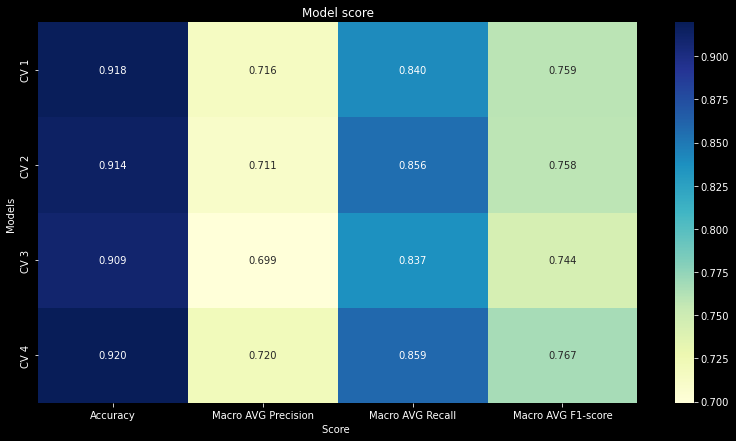

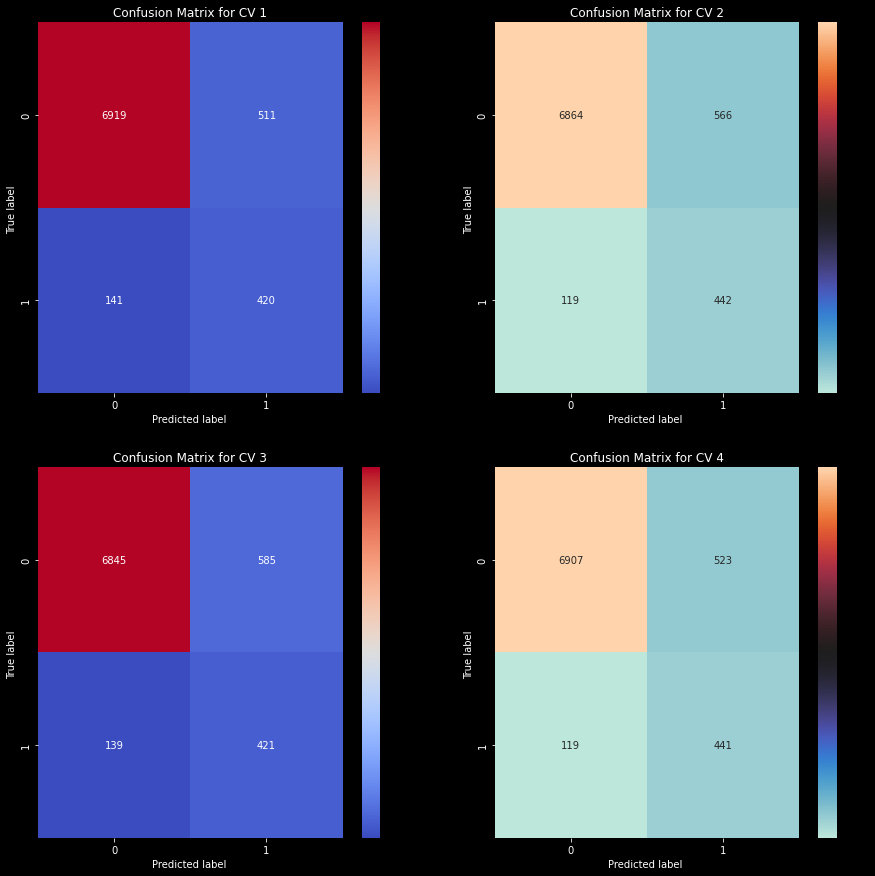

In [39]:
index = ['CV 1' ,'CV 2','CV 3','CV 4']
plot_result()
plot_matrix()